# Matrix Factorization
Matrix Factorization is a class of the collaborative filtering algorithm. The end goal of matrix factorization is basically to build a matrix of users and items filled with known and predicted ratings.

Starting with our sparse (and high-dimensional) original matrix of only known ratings, we want to determine the two factor matrices that are much lower in dimensions that would produce our original matrix. One being the matrix that quantitatively represents the users (user matrix) where each row of the matrix is a vector of size *k* that represents a single user, and the other being the item matrix where each column is a vector of size *k* that represents a single item.

![](https://drive.google.com/uc?id=1ZyzVuhcrOA4iYaw69EaBsqPPdLdDqvFW)

The model is learned by fitting the previously observed ratings. However, the goal is to generalize those previous ratings in a way that predicts future/unknown ratings. 

* Accordingly, each item *i* is associated with a vector *q_i*, and each user *u* is associated with a vector *p_u*.
* For a given item *i*, the elements of *q_i* measure the extent to which the item possesses those factors, positive or negative.
* For a given user *u*, the elements of *p_u* measure the extent of interest the user has in items that are high on the corresponding factors, positive or negative.
* The resulting dot product (*q_i* * *p_u*) captures the interaction between user *u* and item *i*, which is the user’s overall interest in the item’s characteristics:

  ![](https://drive.google.com/uc?id=1--ADw7Bmz6fOOwbLAN2Krd4hcfEdH-7d)

* Some users give high ratings than others, and some items received high ratings than others systematically. Thus, we can extend above equation as follows:

  ![](https://drive.google.com/uc?id=1TZ8SmF-Fsrh93U2Ymx1sSgycn7GZEL4v)

* The model is learned by minimizing a squared error function on the set of known ratings, we order to avoid overfitting the observed data we add an L2 regularization penalty to each element and optimize the learned parameters simultaneously with stochastic gradient descent, as seen in equation below:

  ![](https://drive.google.com/uc?id=1C9D1Fd-FvA6hw12SFHN7m3csCeJpVRtX)



# Model implementation in PyTorch

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [ ]:
# get the data
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2021-01-26 00:54:57--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  17.0MB/s    in 0.3s    

2021-01-26 00:54:58 (17.0 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [ ]:
# read the data
dataset = pd.read_csv('./ml-1m/ratings.dat', sep='::', engine='python', names=('userId', 'movieId','ratings','timestamp'))
print(f'The length of full dataset: {len(dataset)}')

# split the dataset into training and testing datasets
train_df, test_df = train_test_split(dataset, test_size=0.1)

# enconde the data to have contiguous ids for users and movies
lab_enc = LabelEncoder()
train_df['userId'] = lab_enc.fit_transform(train_df['userId'])
train_df['movieId'] =lab_enc.fit_transform(train_df['movieId'])
test_df['userId'] = lab_enc.fit_transform(test_df['userId'])
test_df['movieId'] = lab_enc.fit_transform(test_df['movieId'])

print(f'The length of training data: {len(train_df)}')
print(f'The length of training data: {len(test_df)}')

num_users = dataset['userId'].nunique()
num_movies = dataset['movieId'].nunique()
print(f'Number of unique users: {num_users}')
print(f'Number of unique movies: {num_movies}')

The length of full dataset: 1000209
The length of training data: 900188
The length of training data: 100021
Number of unique users: 6040
Number of unique movies: 3706


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [ ]:
# build our Matrix Factorization Model class
class MF(nn.Module):
    def __init__(self, num_users, num_movies, c_vector=1.0, emb_size=100):
        super(MF, self).__init__()

        # These are the hyper-parameters
        self.num_users = num_users
        self.num_movies = num_movies
        self.c_vector = c_vector
        self.emb_size = emb_size

        # factor matrices and biases which learned and fit by PyTorch
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.movie_emb = nn.Embedding(num_movies, emb_size)
        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)        
        # self.bias = nn.Parameter(torch.ones(1))

        # initializing our matrices with a positive number generally will yield better results
        self.user_emb.weight.data.uniform_(0, 0.5)
        self.movie_emb.weight.data.uniform_(0, 0.5)
        self.user_bias.weight.data.uniform_(-0.01,0.01)
        self.movie_bias.weight.data.uniform_(-0.01,0.01)

    def forward(self, user, movie):
        # vector user
        P = self.user_emb(user)
        # vector movie
        Q = self.movie_emb(movie)
        bias_user = self.user_bias(user).squeeze()
        bias_movie = self.movie_bias(movie).squeeze()
        biases = (bias_user + bias_movie)
        
        # taking the dot product and adding biases to the prediction
        prediction = (P * Q).sum(1) + biases

        return prediction

    def loss(self, prediction, target):
        """
        Function to calculate the loss metric
        """
        # Calculate the Mean Squared Error between target = R_ui and prediction = p_u * q_i
        loss_mse = F.mse_loss(prediction, target.squeeze())

        # Compute L2 regularization over user (P) and item (Q) matrices
        reg_user  = l2_regularize(self.user_emb.weight) * self.c_vector
        reg_movie  = l2_regularize(self.movie_emb.weight) * self.c_vector

        # Add up the MSE loss + user & item regularization
        total_loss = loss_mse + reg_user + reg_movie
        return total_loss

def l2_regularize(array):
    """
    Function to do L2 regularization
    """
    loss = torch.sum(array ** 2.0)
    return loss

In [ ]:
losses = []

# create the training function to train the model on training data
def fit(model, epochs, lr, optimizer):
    model.train()
    for i in range(epochs):
        users = torch.LongTensor(train_df.userId.values)
        movies = torch.LongTensor(train_df.movieId.values)
        ratings = torch.FloatTensor(train_df.ratings.values)
        # compute a prediction for these features
        y_hat = model(users, movies)
        # compute a loss given what the true target outcome was
        loss_mse = model.loss(y_hat, ratings)
        # reset gradient
        optimizer.zero_grad() 
        # backpropagate the loss
        loss_mse.backward()
        # take a step & update the model parameters
        optimizer.step()
        print(f"epoch {i}'s training loss %.3f" % loss_mse.item())
        # record the loss per example
        losses.append(loss_mse.data.numpy())
    evaluate(model)

# create the evaluating function to test the model performance on unseen data
def evaluate(model):
    model.eval()
    users = torch.LongTensor(test_df.userId.values)
    movies = torch.LongTensor(test_df.movieId.values)
    ratings = torch.FloatTensor(test_df.ratings.values)
    # compute a prediction
    y_hat = model(users, movies)
    # compute a loss
    loss_mse = model.loss(y_hat, ratings)
    print("test loss %.3f " % loss_mse.item())

Now let's fit the model, check the loss changes and test the final score on unseen data.

In [ ]:
# Define the Hyper-parameters
epochs = 50
lr = 1e-2  # Learning Rate
emb_size = 10  # Number of dimensions per user, item
c_vector = 1e-6  # regularization constant

# instantiate the model
model = MF(num_users, num_movies, c_vector=c_vector, emb_size=emb_size)
print(model)

# initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Start training the model on training data and evaluate on test data
fit(model, epochs=epochs, lr=lr, optimizer=optimizer)

MF(
  (user_emb): Embedding(6040, 10)
  (movie_emb): Embedding(3706, 10)
  (user_bias): Embedding(6040, 1)
  (movie_bias): Embedding(3706, 1)
)
epoch 0's training loss 10.035
epoch 1's training loss 9.623
epoch 2's training loss 9.210
epoch 3's training loss 8.796
epoch 4's training loss 8.383
epoch 5's training loss 7.972
epoch 6's training loss 7.564
epoch 7's training loss 7.159
epoch 8's training loss 6.759
epoch 9's training loss 6.364
epoch 10's training loss 5.977
epoch 11's training loss 5.598
epoch 12's training loss 5.229
epoch 13's training loss 4.871
epoch 14's training loss 4.524
epoch 15's training loss 4.190
epoch 16's training loss 3.871
epoch 17's training loss 3.567
epoch 18's training loss 3.280
epoch 19's training loss 3.009
epoch 20's training loss 2.757
epoch 21's training loss 2.524
epoch 22's training loss 2.309
epoch 23's training loss 2.114
epoch 24's training loss 1.939
epoch 25's training loss 1.782
epoch 26's training loss 1.645
epoch 27's training loss 1.5

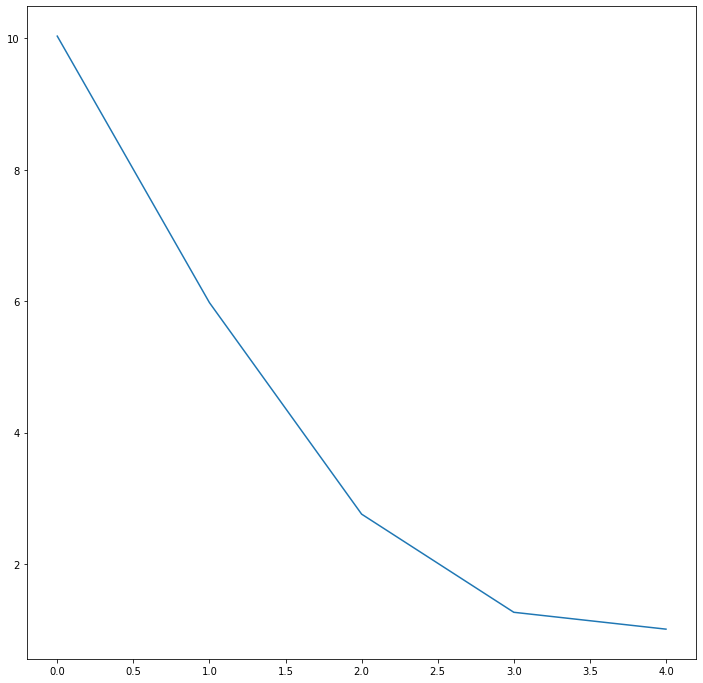

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
n = len(losses)
smooth = np.convolve(losses, np.ones((n,))/n, mode='valid')
plt.figure(figsize=(12, 12))
plt.plot(losses[::10])
plt.plot(smooth, c='r')

# Understand Embeddings

In [ ]:
user_emb = model.user_emb.weight.data.numpy()
movie_emb = model.movie_emb.weight.data.numpy()

Parameter containing:
tensor([[0.4858, 0.6096, 0.5191,  ..., 0.7707, 0.6337, 0.7001],
        [0.3767, 0.4507, 0.6336,  ..., 0.7146, 0.5028, 0.5662],
        [0.5867, 0.6085, 0.8345,  ..., 0.6690, 0.7591, 0.5413],
        ...,
        [0.7683, 0.5625, 0.6199,  ..., 0.5892, 0.6028, 0.4427],
        [0.4760, 0.4837, 0.4201,  ..., 0.4862, 0.7899, 0.5185],
        [0.3558, 0.7587, 0.6887,  ..., 0.6658, 0.4301, 0.4739]],
       requires_grad=True)

In [ ]:
# explore trained latent feature matrices
for name, param in model.named_parameters():
  if name == 'user_emb.weight':
    user_emb = param
  if name == 'movie_emb.weight':
    movie_emb = param

In [ ]:
print(train_df[train_df.userId == 2625])

In [ ]:
# print(train_df[train_df.userId == 2625])
print(train_df[(train_df.userId == 2625) & (train_df.movieId == 3583)]['ratings'])
print()
print((user_emb[2625] * movie_emb[3583]).sum())

# Make predictions

Lets recommend top 10 movies to a user with these steps:



In [ ]:
# make predictions
print(train_df[train_df.userId == 5873])
user = torch.tensor(train_df.iloc[10, 0])
movies = torch.tensor(train_df['movieId'].unique().tolist())
predictions = model(user, movies).tolist()
print(predictions)
normalized_predictions = [i/max(predictions)*5 for i in predictions]
print(normalized_predictions)

sortedIndices = np.array(normalized_predictions).argsort()
recommendations = train_df['movieId'].unique()[sortedIndices][:10]  # taking top 30
print(recommendations)

How to improve the model?


*   Tune hyperparameters
*   List item

